In [1]:
import pandas as pd
import joblib
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from keras.regularizers import l2

In [2]:
from keras.layers import *
from keras.models import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler

In [3]:
X_train = pd.read_csv('C:\\Users\\THIS PC\\Desktop\\apartment-price-prediction\\data\\finalized\\X_train.csv')
y_train = pd.read_csv('C:\\Users\\THIS PC\\Desktop\\apartment-price-prediction\\data\\finalized\\y_train.csv').values.ravel()

In [4]:
preprocessor = joblib.load('C:\\Users\\THIS PC\\Desktop\\apartment-price-prediction\\model\\feature_engineering\\preprocessor.pkl')

In [5]:
X_train_transformed = preprocessor.transform(X_train)

In [6]:
print(type(X_train_transformed))
X_train_transformed

<class 'scipy.sparse._csr.csr_matrix'>


<12483x995 sparse matrix of type '<class 'numpy.float64'>'
	with 112347 stored elements in Compressed Sparse Row format>

In [7]:
dense_matrix = X_train_transformed.toarray()  # Convert to dense

# Step 2: Normalize the data
"""scaler = MinMaxScaler()
dense_matrix_scaled = scaler.fit_transform(dense_matrix)"""

# Step 3: Reshape for LSTM
timesteps = 1  # Define timesteps
n_samples, n_features = dense_matrix.shape
n_sequences = n_samples // timesteps  # Ensure divisible by timesteps

# Reshape to (samples, timesteps, features)
X_lstm = dense_matrix[:n_sequences * timesteps, :].reshape(n_sequences, timesteps, n_features)

print(X_lstm.shape)

(12483, 1, 995)


In [8]:
X_test = pd.read_csv('C:\\Users\\THIS PC\\Desktop\\apartment-price-prediction\\data\\finalized\\X_test.csv')
y_test = pd.read_csv('C:\\Users\\THIS PC\\Desktop\\apartment-price-prediction\\data\\finalized\\y_test.csv').values.ravel()

In [9]:
X_test_transformed = preprocessor.transform(X_test)

In [10]:
dense_matrix_test = X_test_transformed.toarray()  # Convert to dense

# Step 2: Normalize the data
"""scaler = MinMaxScaler()
dense_matrix_scaled = scaler.fit_transform(dense_matrix)"""

# Step 3: Reshape for LSTM
timesteps = 1  # Define timesteps
n_samples, n_features = dense_matrix_test.shape
n_sequences = n_samples // timesteps  # Ensure divisible by timesteps

# Reshape to (samples, timesteps, features)
X_lstm_test = dense_matrix_test[:n_sequences * timesteps, :].reshape(n_sequences, timesteps, n_features)

print(X_lstm_test.shape)

(3121, 1, 995)


In [11]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True), 
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True), 
    Dropout(0.2),
    LSTM(32, activation='relu'), 
    Dropout(0.2),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            575488    
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                1

In [12]:
model.compile(optimizer='adam', loss='mae')

In [13]:
model_path = "C:\\Users\\THIS PC\\Desktop\\apartment-price-prediction\\model\\models"
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True)

In [14]:
history = model.fit(X_lstm, y_train, validation_data=(X_lstm_test, y_test), epochs=200, batch_size=64, callbacks=[early_stopping], )

Epoch 1/200
196/196 [==============================] - 14s 21ms/step - loss: 2.2482 - val_loss: 0.7388
Epoch 2/200
196/196 [==============================] - 3s 14ms/step - loss: 0.9730 - val_loss: 0.6871
Epoch 3/200
196/196 [==============================] - 3s 13ms/step - loss: 0.8497 - val_loss: 0.6133
Epoch 4/200
196/196 [==============================] - 3s 14ms/step - loss: 0.8213 - val_loss: 0.6013
Epoch 5/200
196/196 [==============================] - 3s 16ms/step - loss: 0.7783 - val_loss: 0.5852
Epoch 6/200
196/196 [==============================] - 3s 14ms/step - loss: 0.7691 - val_loss: 0.5820
Epoch 7/200
196/196 [==============================] - 2s 11ms/step - loss: 0.7375 - val_loss: 0.6115
Epoch 8/200
196/196 [==============================] - 2s 12ms/step - loss: 0.7323 - val_loss: 0.5918
Epoch 9/200
196/196 [==============================] - 3s 16ms/step - loss: 0.7074 - val_loss: 0.5591
Epoch 10/200
196/196 [==============================] - 3s 17ms/step - loss: 0.70

In [15]:
y_pred_train = model.predict(X_lstm)

391/391 [==============================] - 3s 5ms/step


In [16]:
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

In [17]:
print("test: ", mae, rmse)

test:  0.3689486861593743 0.5646038317384511


In [18]:
y_pred_test = model.predict(X_lstm_test)

98/98 [==============================] - 1s 5ms/step


In [19]:
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("test: ", mae, rmse)

test:  0.5086971067977387 0.7352071610697392


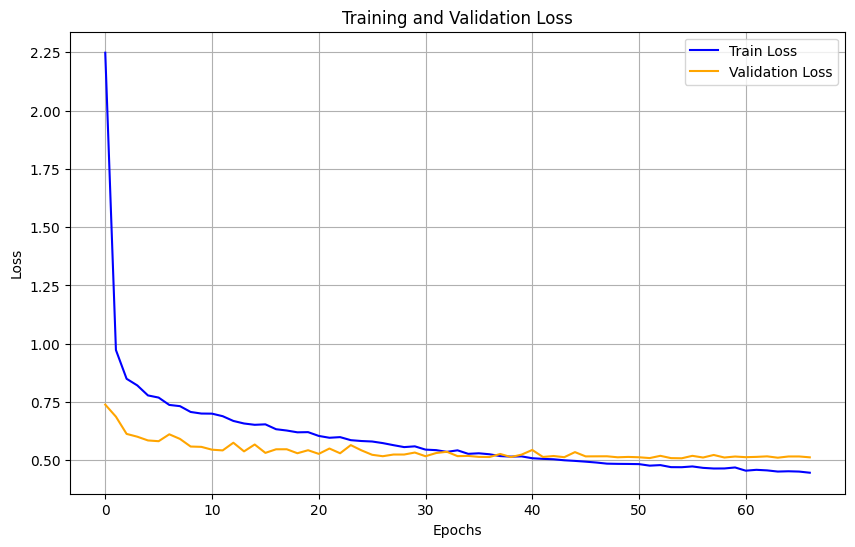

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [21]:
model.save(os.path.join(model_path,'lstm_apartment_model.h5'))